# Develop Model
In this noteook, we will go through the steps to load the ResNet152 model, pre-process the images to the required format and call the model to find the top predictions.

    Note: Always make sure you don't have any lingering notebooks running (Shutdown previous notebooks). Otherwise it may cause GPU memory issue.

In [1]:
import numpy as np
from PIL import Image, ImageOps
import wget
from resnet152 import ResNet152
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from azureml.core.workspace import Workspace
from dotenv import set_key, find_dotenv
from testing_utilities import get_auth


Using TensorFlow backend.
/anaconda/envs/deployment_aml/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda/envs/deployment_aml/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda/envs/deployment_aml/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda/envs/deployment_aml/lib/p

In [2]:
env_path = find_dotenv(raise_error_if_not_found=True)

## Create the model

In [3]:
# If you see error msg "InternalError: Dst tensor is not initialized.", it indicates there are not enough memory.
model = ResNet152(weights="imagenet")
print("model loaded")









243187712/243179624 [==============================] - 3s 0us/step
model loaded


In [4]:
wget.download(
    "https://bostondata.blob.core.windows.net/aksdeploymenttutorialaml/220px-Lynx_lynx_poing.jpg"
)

'220px-Lynx_lynx_poing.jpg'

(220, 330)


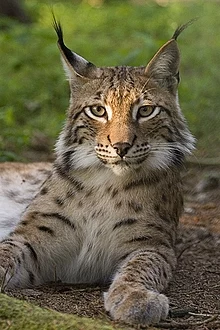

In [5]:
img_path = "220px-Lynx_lynx_poing.jpg"
print(Image.open(img_path).size)
Image.open(img_path)

Below, we load the image by resizing to (224, 224) and then preprocessing using the methods from keras preprocessing and imagenet utilities.

In [6]:
# Evaluate the model using the input data
img = Image.open(img_path).convert("RGB")
img = ImageOps.fit(img, (224, 224), Image.ANTIALIAS)
img = np.array(img)  # shape: (224, 224, 3)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)

Now, let's call the model on our image to predict the top 3 labels. This will take a few seconds.

In [7]:
%%time
preds = model.predict(img)
decoded_predictions = decode_predictions(preds, top=3)
print("Predicted:", decoded_predictions)
resp = {img_path: str(decoded_predictions)}

40960/35363 [==================================] - 0s 0us/step
Predicted: [[('n02127052', 'lynx', 0.9784429), ('n02128385', 'leopard', 0.010881074), ('n02123159', 'tiger_cat', 0.0036899238)]]
CPU times: user 4.85 s, sys: 320 ms, total: 5.17 s
Wall time: 5.6 s


## Register the model
Register an existing trained model, add descirption and tags.

In [8]:
# Get workspace
# Load existing workspace from the config file info.

ws = Workspace.from_config(auth=get_auth())
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep="\n")

workspace
azuremlresourcegroup
eastus
32cf04de-62b6-46b8-b31a-863d7fd95678


In [9]:
model.save_weights("model_resnet_weights.h5")

In [10]:
# Register the model
from azureml.core.model import Model

In [11]:
model = Model.register(
    model_path="model_resnet_weights.h5",  # this points to a local file
    model_name="resnet_model",  # this is the name the model is registered as
    tags={"model": "dl", "framework": "resnet"},
    description="resnet 152 model",
    workspace=ws,
)

Registering model resnet_model


In [12]:
print(model.name, model.description, model.version)

resnet_model resnet 152 model 1


In [13]:
set_key(env_path, "model_version", str(model.version))

(True, 'model_version', '1')

In [14]:
# Clear GPU memory
from keras import backend as K

In [15]:
K.clear_session()

We have registred the trained ResNet152 model in Azure ML. We can now move on to [developing the model api for our model](02_DevelopModelDriver.ipynb).